# Readme

Cross validation for the model 'rnn 1', 'rnn 2', ..., 'rnn 24'.

# Setup

In [1]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import time
import random
import pickle
import json
import itertools
import importlib
import os

/home/mmip/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import sys
sys.path.append ('functions')

import functions as mf
importlib.reload(mf) 

from rnn_module import AmmoniaRNN

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [4]:
pd.set_option("display.max_columns", None)

# Data processing

## Data no embeddings

In [5]:
data_no_embeddings = pd.read_csv("../00_data_preparation/processed_data/data_rnn_1.csv")

In [6]:
data_no_embeddings = data_no_embeddings.drop(['Unnamed: 0'], axis = 1)

In [7]:
data_no_embeddings.shape

(6169, 26)

In [8]:
data_no_embeddings.head (2)

,e.cum,delta_e.cum,e.cum_shift,e.rel,j.NH3,pmid,meas.tech,country,inst,ct,dt,air.temp,wind.2m,rain.rate,tan.app,app.rate,man.dm,man.ph,man.source,t.incorp,app.mthd_bc,app.mthd_bsth,app.mthd_ts,app.mthd_os,incorp_none,incorp_shallow
0,7.1480,7.1480,0.000,0.058537,1.7870,182,micro met,DK,104,4.0,4.0,8.20,8.10,0.0,122.11,31.8,3.7,7.35,0,1000.0,1,0,0,0,1,0
1,8.2921,1.1441,7.148,0.067907,0.0673,182,micro met,DK,104,21.0,17.0,4.45,3.98,0.0,122.11,31.8,3.7,7.35,0,1000.0,1,0,0,0,1,0


## Data embeddings

In [9]:
data_embeddings = pd.read_csv("../00_data_preparation/processed_data/data_rnn_2.csv")

In [10]:
data_embeddings = data_embeddings.drop(['Unnamed: 0'], axis = 1)

In [11]:
data_embeddings.shape

(6169, 22)

In [12]:
data_embeddings.head (2)

,e.cum,delta_e.cum,e.cum_shift,e.rel,j.NH3,pmid,meas.tech,country,inst,ct,dt,air.temp,wind.2m,rain.rate,tan.app,app.rate,man.dm,man.ph,man.source,t.incorp,app.mthd,incorp
0,7.1480,7.1480,0.000,0.058537,1.7870,182,micro met,DK,104,4.0,4.0,8.20,8.10,0.0,122.11,31.8,3.7,7.35,0,1000.0,0,0
1,8.2921,1.1441,7.148,0.067907,0.0673,182,micro met,DK,104,21.0,17.0,4.45,3.98,0.0,122.11,31.8,3.7,7.35,0,1000.0,0,0


## Test samples

In [13]:
with open("../00_data_preparation/processed_data/list_train_pmids.json", "r") as f:
    list_train_pmids = json.load(f)

with open("../00_data_preparation/processed_data/list_eval_pmids.json", "r") as f:
    list_eval_pmids = json.load(f)

with open("../00_data_preparation/processed_data/list_test_pmids.json", "r") as f:
    list_test_pmids = json.load(f)

In [14]:
len (list_train_pmids)

15

# Cross validation

In [15]:
response = ["e.cum", "delta_e.cum", "e.cum and delta_e.cum"]
bidirectional = [True, False]
mlp = [True, False]
with_embeddings = [True, False]
num_params = [None]

hyper_grid = pd.DataFrame(
    itertools.product(response, bidirectional, mlp, with_embeddings, num_params), 
    columns=["response", "bidirectional", "mlp", "with_embeddings", "num_params"]
)

hyper_grid.insert(0, "model", range(1, len(hyper_grid) + 1))

hyper_grid.style.hide(axis="index")

model,response,bidirectional,mlp,with_embeddings,num_params
1,e.cum,True,True,True,None
2,e.cum,True,True,False,None
3,e.cum,True,False,True,None
4,e.cum,True,False,False,None
5,e.cum,False,True,True,None
6,e.cum,False,True,False,None
7,e.cum,False,False,True,None
8,e.cum,False,False,False,None
9,delta_e.cum,True,True,True,None
10,delta_e.cum,True,True,False,None


In [16]:
p = 15

In [17]:
folder_path = "results/05_1_model_comparison/df_res"

df_list = []

for file in os.listdir(folder_path):
    if file.endswith(".csv"):  
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)  
        df_list.append(df)

df_all_predictions = pd.concat(df_list, ignore_index=True)

In [18]:
df_all_predictions.shape

(239424, 13)

In [19]:
df_all_predictions.head (2)

,sample,model,pmid,e.cum,delta_e.cum,ct,dt,air.temp,wind.2m,rain.rate,prediction_ecum,prediction_delta_ecum,running_time
0,11,19,190,10.586,10.586,4.25,4.25,12.52,4.02,0.047059,5.294902,6.012060,19.602061
1,11,19,190,15.530,4.944,19.75,15.50,9.64,3.16,0.000000,6.804937,0.796497,19.602061


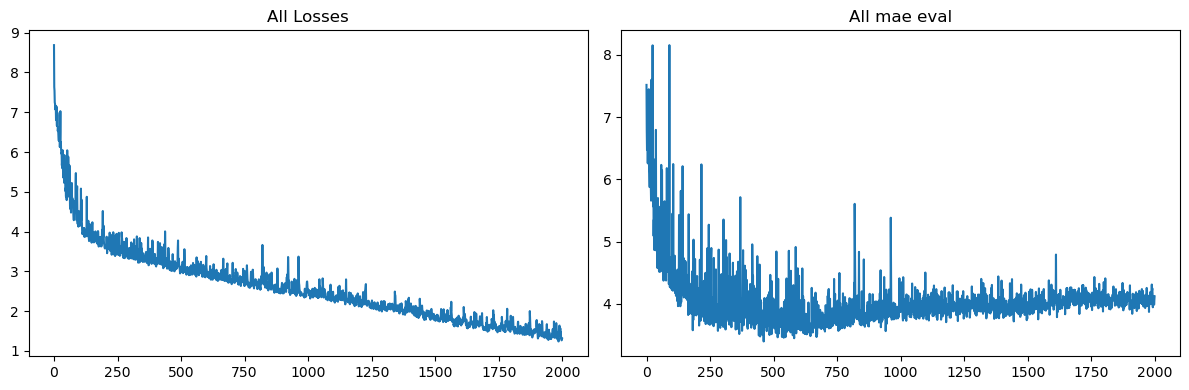

In [20]:
model_index = 1
sample = 0

with open(f'results/05_1_model_comparison/all_mae_eval/all_mae_eval_sample_{sample}_model_{model_index}.pkl', "rb") as f:
    all_mae_eval = pickle.load(f)

with open(f'results/05_1_model_comparison/all_losses/all_losses_sample_{sample}_model_{model_index}.pkl', "rb") as f:
    all_losses = pickle.load(f)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

axes[0].plot(all_losses)
axes[0].set_title('All Losses')

axes[1].plot(all_mae_eval)
axes[1].set_title('All mae eval')

plt.tight_layout()
plt.show()

# Number of parameters

In [21]:
response = ["e.cum", "delta_e.cum", "e.cum and delta_e.cum"]
bidirectional = [True, False]
mlp = [True, False]
with_embeddings = [True, False]
num_params = [None]

models = pd.DataFrame(
    itertools.product(response, bidirectional, mlp, with_embeddings, num_params), 
    columns=["response", "bidirectional", "mlp", "with_embeddings", "num_params"]
)

models.insert(0, "model", range(1, len(models) + 1))

models.style.hide(axis="index")

model,response,bidirectional,mlp,with_embeddings,num_params
1,e.cum,True,True,True,None
2,e.cum,True,True,False,None
3,e.cum,True,False,True,None
4,e.cum,True,False,False,None
5,e.cum,False,True,True,None
6,e.cum,False,True,False,None
7,e.cum,False,False,True,None
8,e.cum,False,False,False,None
9,delta_e.cum,True,True,True,None
10,delta_e.cum,True,True,False,None


In [22]:
for l in range (len (models)):

    hidden_size = 512
    num_layers = 1
    nonlinearity = "relu"
    
    bidirectional = models['bidirectional'][l]
    bidirectional = bidirectional.item()
    mlp = models['mlp'][l]
    mlp = mlp.item()
    with_embeddings = models['with_embeddings'][l]
    with_embeddings = with_embeddings.item()
    response = models['response'][l]
   
     
    
    if (with_embeddings):
        data = data_embeddings
        cat_dims = [5, 3, 2]  
        embedding_dims = [10, 9, 8]  
        input_size = 13 
    
    else: 
        data = data_no_embeddings.copy()
        cat_dims = None
        embedding_dims = None
        input_size = 17
        
    output_size = 1
    if (response == "e.cum and delta_e.cum"): output_size = 2
            
    
    torch.manual_seed(1)
    model = AmmoniaRNN(input_size = input_size, 
                       output_size = output_size, 
                       hidden_size = hidden_size, 
                       nonlinearity = nonlinearity,
                       num_layers = num_layers,
                       bidirectional = bidirectional,
                       mlp = mlp,
                       with_embeddings = with_embeddings, 
                       cat_dims = cat_dims, 
                       embedding_dims = embedding_dims).to(DEVICE)

    num_params = sum(p.numel() for p in model.parameters())

    models.loc[l, 'num_params'] = num_params

models.to_csv('results/rnn_models.csv', index = False)

In [23]:
models

,model,response,bidirectional,mlp,with_embeddings,num_params
0,1,e.cum,True,True,True,570474
1,2,e.cum,True,True,False,549901
2,3,e.cum,True,False,True,565342
3,4,e.cum,True,False,False,544769
4,5,e.cum,False,True,True,285290
5,6,e.cum,False,True,False,274957
6,7,e.cum,False,False,True,282718
7,8,e.cum,False,False,False,272385
8,9,delta_e.cum,True,True,True,570474
9,10,delta_e.cum,True,True,False,549901


# End